<a href="https://colab.research.google.com/github/AmirKage/TDS-GroupProject24-25/blob/Final-Project_Chia-Yang-Kao/Testing_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install HuggingFace Library
!pip install transformers

# Import Necessary Libraries
from transformers import pipeline

In [2]:
import json

# Path to your JSON file
file_path = r"/content/Q&ADataset2.json"  # Ensure this is the full path to your JSON file, including the file name.

# Load JSON data
with open(file_path, "r", encoding="utf-8-sig") as file: #encoding="utf-8-sig" handles potential Byte Order Mark (BOM) characters
    data = json.load(file)

# Function to categorize answers based on length
def categorize_answer_length(answer_text):
    word_count = len(answer_text.split())
    if word_count <= 5:
        return "short"
    elif word_count <= 20:
        return "moderate"
    else:
        return "long"

# Add difficulty field to each answer, but only if 'answers' key exists
for item in data:
    # Check if the 'answers' key exists in the current item
    if "answers" in item:
        for answer in item["answers"]:
            answer["difficulty"] = categorize_answer_length(answer["text"])



# Save the updated dataset
updated_file_path = r"/content/questionnaire_labeled.json" # Update with desired save path
with open(updated_file_path, "w", encoding="utf-8") as file:
    json.dump(data, file, indent=4)  # indent=4 for pretty printing

print(f"Labeled dataset saved to {updated_file_path}")

Labeled dataset saved to /content/questionnaire_labeled.json


In [3]:
# Install HuggingFace Library
!pip install transformers

# Import Necessary Libraries
from transformers import pipeline
import json
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt



In [4]:
# Initialize the question-answering pipeline
qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu


In [5]:
# Path to labeled dataset
labeled_data_path = r"/content/questionnaire_labeled.json"

# Load labeled dataset
with open(labeled_data_path, "r", encoding="utf-8") as file:
    labeled_data = json.load(file)

print(f"Loaded {len(labeled_data)} entries in labeled_data.")


Loaded 20 entries in labeled_data.


In [6]:
results = []

for item in labeled_data:
    question = item["question"]
    context = item["context"]

    print(f"Processing Question: {question}")

    # Skip if no answers are available
    if "answers" not in item or not item["answers"]:
        print(f"Skipping Question: {question}, no answers found.")
        continue

    # Iterate through all standard answers
    for answer in item["answers"]:
        # Use Hugging Face model to generate answer
        model_output = qa_pipeline({"question": question, "context": context})

        # Append results
        results.append({
            "Question": question,
            "Context": context,
            "Model Answer": model_output.get("answer", ""),
            "Correct Answer": answer["text"],
            "Difficulty": answer.get("difficulty", "N/A"),
            "Score": model_output.get("score", 0),
            "Is Correct": model_output.get("answer", "").strip().lower() == answer["text"].strip().lower()
        })

# Print the first few results for verification
for res in results[:5]:
    print(res)



Processing Question: What role does guilt play in Amir's relationship with Hassan in 'The Kite Runner'?
Skipping Question: What role does guilt play in Amir's relationship with Hassan in 'The Kite Runner'?, no answers found.
Processing Question: How does Jane Eyre assert her independence in the face of societal norms?
Skipping Question: How does Jane Eyre assert her independence in the face of societal norms?, no answers found.
Processing Question: What does the green light symbolize in 'The Great Gatsby'?
Skipping Question: What does the green light symbolize in 'The Great Gatsby'?, no answers found.
Processing Question: How does George Orwell explore the theme of surveillance in '1984'?
Skipping Question: How does George Orwell explore the theme of surveillance in '1984'?, no answers found.
Processing Question: What role does social class play in the relationships depicted in 'Pride and Prejudice'?
Skipping Question: What role does social class play in the relationships depicted in '

In [8]:
# Calculate accuracy by difficulty
accuracy_by_difficulty = defaultdict(lambda: {"correct": 0, "total": 0})

for res in results:
    difficulty = res["Difficulty"]
    accuracy_by_difficulty[difficulty]["total"] += 1
    if res["Is Correct"]:
        accuracy_by_difficulty[difficulty]["correct"] += 1

# Print accuracy for each difficulty level
for difficulty, stats in accuracy_by_difficulty.items():
    accuracy = stats["correct"] / stats["total"] * 100
    print(f"Accuracy for {difficulty} answers: {accuracy:.2f}%")




In [9]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV file
results_file_path = r"/content/qa_results.csv"
results_df.to_csv(results_file_path, index=False)

print(f"Results saved to {results_file_path}")



Results saved to /content/qa_results.csv


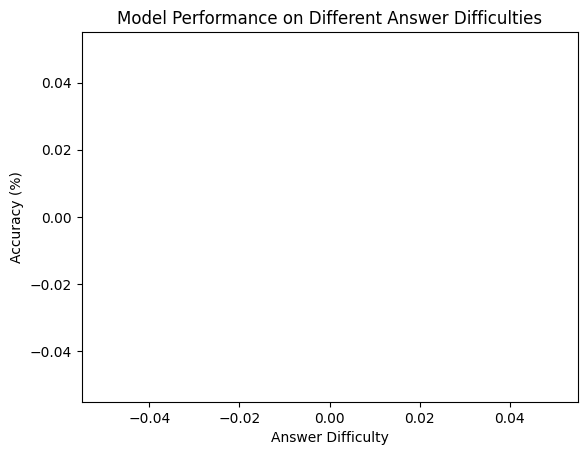

In [10]:
# Prepare data for visualization
difficulties = list(accuracy_by_difficulty.keys())
accuracies = [accuracy_by_difficulty[d]["correct"] / accuracy_by_difficulty[d]["total"] * 100 for d in difficulties]

# Plot bar chart
plt.bar(difficulties, accuracies)
plt.xlabel("Answer Difficulty")
plt.ylabel("Accuracy (%)")
plt.title("Model Performance on Different Answer Difficulties")
plt.show()


In [11]:
import random
import json

# Categories and word length ranges
categories = ["positive", "neutral", "negative"]
word_length_ranges = {
    "short": (3, 5),     # 3-5 words
    "moderate": (6, 15), # 6-15 words
    "long": (16, 30)     # 16-30 words
}

# Generate a random answer with the specified word length range
def generate_random_answer(category, length_range):
    sentiment_prefixes = {
        "positive": ["I loved", "It's amazing", "The movie was wonderful"],
        "neutral": ["It was okay", "The movie is average", "Not bad"],
        "negative": ["I didn't like", "It was disappointing", "Terrible movie"]
    }
    prefix = random.choice(sentiment_prefixes[category])
    remaining_length = random.randint(*length_range) - len(prefix.split())
    words = ["great", "scenes", "characters", "beautiful", "monstrous", "plot", "action", "love", "epic", "cinema"]
    filler = " ".join(random.choices(words, k=max(remaining_length, 0)))
    return f"{prefix} {filler}".strip()

# Generate the dataset
dataset = []
for _ in range(50):
    category = random.choice(categories)
    difficulty = random.choice(list(word_length_ranges.keys()))
    answer = generate_random_answer(category, word_length_ranges[difficulty])
    dataset.append({
        "question": "What is your opinion about the movie King Kong?",
        "answer": answer,
        "category": category,
        "difficulty": difficulty
    })

# Print the dataset in a readable format
for entry in dataset:
    print(json.dumps(entry, indent=4))

# Save the dataset to a JSON file
output_file = "king_kong_answers.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(dataset, f, indent=4, ensure_ascii=False)

print(f"Dataset saved to {output_file}")


{
    "question": "What is your opinion about the movie King Kong?",
    "answer": "Not bad great action",
    "category": "neutral",
    "difficulty": "short"
}
{
    "question": "What is your opinion about the movie King Kong?",
    "answer": "I didn't like love cinema action scenes epic",
    "category": "negative",
    "difficulty": "moderate"
}
{
    "question": "What is your opinion about the movie King Kong?",
    "answer": "Terrible movie beautiful love monstrous beautiful cinema love great epic beautiful scenes scenes cinema characters great love beautiful great characters love scenes cinema plot",
    "category": "negative",
    "difficulty": "long"
}
{
    "question": "What is your opinion about the movie King Kong?",
    "answer": "The movie is average characters action great monstrous beautiful epic monstrous beautiful characters love",
    "category": "neutral",
    "difficulty": "moderate"
}
{
    "question": "What is your opinion about the movie King Kong?",
    "answer